M3. Actividad 
Angel Guillermo Bosquez Baltazar
Emiliano Joel Lopez Jimenez

1. Objetivo y descripcion del modelo: 
El objetivoes simular una intersección de carreteras con semaforos inteligentes.
A diferencia de los semaforos tradicionales de tiempos fijos, el modelo responde depende a las peticiones de agentes de coches


2. Defnición de Agentes

A. Agente Coche(Car)
    Su roll es navegar de un punto de spawn hasta el final de la calle respetando los semaforos y evitando choques
    Capacidades
    -Sabe su posicion en el mapa, la distancia hasta el cruce y el estado actual del semaforo
    -Transmite su tiempo de llegada al semaforo
    -Puede frenar o avanzar dependiendo si tiene coches adelante 
    -En el caso de que se encuentre en la interseccion y por timeout el semaforo se ponga en rojo, decide segir avanzando para liberar el espacio 
 
B. Agente Semáforo Inteligente (Semaphore)
    Administra el acceso a la interseccion 
    Su estado base es de amarillo, mientras no haya solicitudes de paso se queda en este color 
    Capacidades
    -Recibe mensajes de solicitud de paso
    -Mantiene colade prioridad dependiendo llegada de coches
    -Tiene un tiempo maximo permitido para que un solo lado no se adueñe del paso


El semaforo procesa solicitudes basandose en tiemp oestimada de llegada, el vehiculo mas proximo recibe priroridad de paso

Si llegan mas coches de diferentes direcciones el semaforo las agrupa, cuando se le da paso a una direccion se mantiene luz verde hasta que se vence el tiempo max o se vacia la cola, luego se le da paso al grupo contrario 




In [29]:
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid
from mesa.visualization import SolaraViz, SpaceRenderer, make_plot_component
from mesa.visualization.components import AgentPortrayalStyle, PropertyLayerStyle


#constantes del mapa para definir tipos de terreno, van a servir para la siguiente parte
TERRAIN_BUILDING = 0 
TERRAIN_ROAD_V = 1
TERRAIN_ROAD_H = 2
TERRAIN_INTERSECTION = 3

In [ ]:
class Semaphore(CellAgent):
    def __init__(self, model, cell):
        super().__init__(model)
        self.cell = cell
        self._state = "yellow" #estado inicial en reposo
        
        #configuracion de tiempos 
        self._timer = 0
        self._min_time = 10 #tiempo minimo que dura un verde
        self._max_limit = 30 #limite duro para cortar el paso si hay demasiados coches
        self._current_elapsed = 0 #contador de cuanto tiempo llevamos en verde
        
        #colas de espera separadas por direccion
        self._queue_ns = [] #norte sur
        self._queue_ew = [] #este oeste
        self._last_green = None #memoria del ultimo turno para evitar embotellamiento
        self.orientation = "horizontal"

    #setter
    @property
    def passage_request(self):
        return (self._queue_ns, self._queue_ew)

    @passage_request.setter
    def passage_request(self, message):
        #desempaquetamos el mensaje enviado por el coche
        arrival_time, direction, car_id = message
        
        #encolamos la solicitud en la lista correspondiente segun de donde viene
        if direction in ["north", "south"]:
            self._queue_ns.append((arrival_time, car_id))
        else:
            self._queue_ew.append((arrival_time, car_id))
            
        #reactividad si el semaforo estaba dormido yellow despierta y decide
        if self._state == "yellow":
            self._decide_next_state()

    #logica de control y estado publico
    @property
    def state(self):
        return self._state

    def _decide_next_state(self):
        #contamos cuantos coches hay en cada cola
        ns_count = len(self._queue_ns)
        ew_count = len(self._queue_ew)
        
        #caso 1 nadie espera asi que volvemos a dormir para ahorrar recursos
        if ns_count == 0 and ew_count == 0:
            self._state = "yellow"
            self._timer = 0
            self._current_elapsed = 0
            return

        #caso 2 decision de a quien le toca el verde
        next_side = ""
        
        #si solo un lado tiene coches gana ese lado automaticamente
        if ns_count > 0 and ew_count == 0:
            next_side = "ns"
        elif ew_count > 0 and ns_count == 0:
            next_side = "ew"
        else:
            #cambio 1 logica para evitar embotellamineto
            #si ambos lados tienen coches forzamos la alternancia basandonos en la memoria
            if self._last_green == "ns":
                next_side = "ew"
            elif self._last_green == "ew":
                next_side = "ns"
            else:
                #si es la primera vez el que tenga mas gana 
                next_side = "ns" if ns_count >= ew_count else "ew"

        #ejecucion del cambio de estado
        if next_side == "ns":
            self._state = "green_ns"
            self._last_green = "ns"
            #cambio 2 tiempo dinamico calculamos duracion base mas un bono por demanda
            self._timer = min(10 + (ns_count * 2), self._max_limit)
            #asumimos que los de la cola pasaran y limpiamos la lista
            self._queue_ns = []
        else:
            self._state = "green_ew"
            self._last_green = "ew"
            self._timer = min(10 + (ew_count * 2), self._max_limit)
            self._queue_ew = []
            
        self._current_elapsed = 0

    def step(self):
        #ciclo de vida del semaforo contar tiempo hacia atras
        if self._timer > 0:
            self._timer -= 1
            self._current_elapsed += 1
        
        #limite de seguridad
        #si excedemos el tiempo maximo cortamos el verde aunque el timer siga
        if self._current_elapsed >= self._max_limit:
            self._timer = 0

        #si el tiempo acabo y no estamos en reposo decidimos el siguiente estado
        if self._timer == 0 and self._state != "yellow":
            self._decide_next_state()

#agente secundario para visualizacion
class SecondarySemaphore(CellAgent):
    def __init__(self, model, cell, primary, orientation):
        super().__init__(model)
        self.cell = cell
        self.primary = primary 
        self.orientation = orientation

Component react.component(mesa.visualization.solara_viz.SpaceRendererComponent) raised exception AttributeError("'NoneType' object has no attribute 'x'")
Traceback (most recent call last):
  File "/Users/durandal/Desktop/TEC/Agentes/.venv/lib/python3.13/site-packages/reacton/core.py", line 1702, in _render
    root_element = el.component.f(*el.args, **el.kwargs)
  File "/Users/durandal/Desktop/TEC/Agentes/.venv/lib/python3.13/site-packages/mesa/visualization/solara_viz.py", line 278, in SpaceRendererComponent
    renderer.draw_agents(
    ~~~~~~~~~~~~~~~~~~~~^
        agent_portrayal=renderer.agent_portrayal, **renderer.agent_kwargs
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/durandal/Desktop/TEC/Agentes/.venv/lib/python3.13/site-packages/mesa/visualization/space_renderer.py", line 196, in draw_agents
    arguments = self.backend_renderer.collect_agent_data(
        self.space, agent_portrayal, default_size=self.space_drawer.s_de

In [31]:
class Car(CellAgent):
    def __init__(self, model, cell, direction, traffic_light):
        super().__init__(model)
        self.cell = cell
        self.direction = direction
        self.traffic_light = traffic_light
        self._speed = 1
        self._has_requested = False

    @property
    def speed(self):
        return self._speed

    @speed.setter
    def speed(self, value):
        self._speed = max(0, value)

    def step(self):
        #percepcion, aqui conviene mas la distancia de manhattan por que se trata de una liena recta y el semaforo esta en el centro
        dist_to_center = self.manhattan_distance(self.cell.coordinate, (20, 20))
        x, y = self.cell.coordinate
        current_terrain = self.model.grid.road.data[x, y]
        is_inside_intersection = (current_terrain == TERRAIN_INTERSECTION)

        #comunicacion, solicitud de paso si estamos cerca del semaforo y no hemos pedido aun
        if dist_to_center < 15 and not self._has_requested:
            arrival_time = dist_to_center / self.speed if self.speed > 0 else 99
            self.traffic_light.passage_request = (arrival_time, self.direction, self.unique_id)
            self._has_requested = True

        #decision de movimiento
        
        # correccion hecha con ia, el coche ve si el semaforo esta verde para continuar, frena en rojo o amarillo 
        light = self.traffic_light.state
        is_green_for_me = False
        
        #solo avanzo si es explicitamente verde para mi direccion
        if light == "green_ns" and self.direction in ["north", "south"]: 
            is_green_for_me = True
        elif light == "green_ew" and self.direction in ["east", "west"]: 
            is_green_for_me = True
            
        #regla don t block the box
        should_stop_light = False
        if not is_inside_intersection:
            #lookahead
            next_pos_check = self._get_next_pos()
            future_is_intersection = False
            
            nx, ny = next_pos_check
            if 0 <= nx < self.model.grid.width and 0 <= ny < self.model.grid.height:
                if self.model.grid.road.data[nx, ny] == TERRAIN_INTERSECTION:
                    future_is_intersection = True
            
            #si voy a entrar al cruce y no es. verde
            if future_is_intersection and not is_green_for_me:
                 should_stop_light = True

         

        #verificar trafico 
        next_pos = self._get_next_pos()
        car_ahead = self._check_car_ahead(next_pos)
        
        #jerarquia final
        if car_ahead:
            self.speed = 0 
        elif should_stop_light:
            self.speed = 0 
        else:
            self.speed = 1 
            self._move_to(next_pos)

    #utilidad para moverse y detectar coches adelante
    def _get_next_pos(self):
        x, y = self.cell.coordinate
        if self.direction == "north": y += 1
        elif self.direction == "south": y -= 1
        elif self.direction == "east": x += 1
        elif self.direction == "west": x -= 1
        return (x, y)
    
    def _check_car_ahead(self, pos):
        if self.cell.neighborhood:
            target_cell = next((n for n in self.cell.neighborhood.cells if n.coordinate == pos), None)
            if target_cell:
                return any(isinstance(a, Car) for a in target_cell.agents)
        return False

    def _move_to(self, pos):
        x, y = pos
        if 0 <= x < self.model.grid.width and 0 <= y < self.model.grid.height:
            terrain = self.model.grid.road.data[x, y]
            if terrain != TERRAIN_BUILDING:
                target_cell = None
                if self.cell.neighborhood:
                    target_cell = next((n for n in self.cell.neighborhood.cells if n.coordinate == pos), None)
                if not target_cell:
                    target_cell = next((c for c in self.model.grid.all_cells if c.coordinate == pos), None)
                if target_cell:
                    self.cell = target_cell
        else:
            self.remove()

    def manhattan_distance(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

In [32]:
class TrafficModel(mesa.Model):
    def __init__(self, num_cars=5):
        super().__init__()
        self.width = 42
        self.height = 42
        self.num_cars = num_cars
        self.running = True
        
        self.grid = OrthogonalMooreGrid((42, 42), torus=False, capacity=10, random=self.random) 
        
        self.grid.create_property_layer("road", default_value=TERRAIN_BUILDING, dtype=np.uint8)
        self._init_map()

        #buscamos la celda central para el primary usando next
        primary_cell = next(c for c in self.grid.all_cells if c.coordinate == (20, 20))
        self.traffic_light = Semaphore(self, primary_cell)
        
        #configuracion de semaforos secundarios para visualizacion
        secondary_configs = [
            ((21, 21), "horizontal"),
            ((20, 21), "vertical"),
            ((21, 20), "vertical")
        ]
        
        for pos, orient in secondary_configs:
            cell = next(c for c in self.grid.all_cells if c.coordinate == pos)
            SecondarySemaphore(self, cell, self.traffic_light, orient)

        self.spawn_timer = 0
        
        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Cars": lambda m: len([a for a in m.agents if isinstance(a, Car)]),
                "Queue": lambda m: len(m.traffic_light.passage_request[0]) + len(m.traffic_light.passage_request[1])
            }
        )
        self._throughput_counter = 0

    def get_throughput(self):
        return self._throughput_counter

    def _init_map(self):
        #dibujamos las calles directamente en la matriz de datos data
        #calles verticales
        for y in range(42):
            self.grid.road.data[20, y] = TERRAIN_ROAD_V
            self.grid.road.data[21, y] = TERRAIN_ROAD_V
        #calles horizontales
        for x in range(42):
            self.grid.road.data[x, 20] = TERRAIN_ROAD_H
            self.grid.road.data[x, 21] = TERRAIN_ROAD_H
        
        #definimos la zona de interseccion central 2x2
        self.grid.road.data[20, 20] = TERRAIN_INTERSECTION
        self.grid.road.data[20, 21] = TERRAIN_INTERSECTION
        self.grid.road.data[21, 20] = TERRAIN_INTERSECTION
        self.grid.road.data[21, 21] = TERRAIN_INTERSECTION

    def step(self):
        #primero semaforo
        self.traffic_light.step()
        
        #contamos coches antes y despues para medir el flu
        cars_before = len([a for a in self.agents if isinstance(a, Car)])
        self.agents.shuffle_do("step")
        cars_after = len([a for a in self.agents if isinstance(a, Car)])
        
        if cars_after < cars_before:
            self._throughput_counter += (cars_before - cars_after)
        
        #generacion de trafico
        self.spawn_timer += 1
        if self.spawn_timer > (100 // (self.num_cars + 1)): 
            self._spawn_car()
            self.spawn_timer = 0
            
        self.datacollector.collect(self)
        
        self.final_queue = len(self.traffic_light.passage_request[0]) + len(self.traffic_light.passage_request[1])
        self.final_throughput = self._throughput_counter

    def _spawn_car(self):
        spawns = [
            ((20, 41), "south"), ((21, 0), "north"), 
            ((0, 20), "east"),   ((41, 21), "west")   
        ]
        pos, direction = self.random.choice(spawns)
        
        cell = next((c for c in self.grid.all_cells if c.coordinate == pos), None)
        
        if cell:
            #verificamos si la celda esta libre para no encimar coches
            has_car = any(isinstance(x, Car) for x in cell.agents)
            if not has_car:
                Car(self, cell, direction, self.traffic_light)

Cannot show ipywidgets in text

Error in callback <function _draw_all_if_interactive at 0x113d3e840> (for post_execute), with arguments args (),kwargs {}:


AttributeError: 'NoneType' object has no attribute 'bbox'

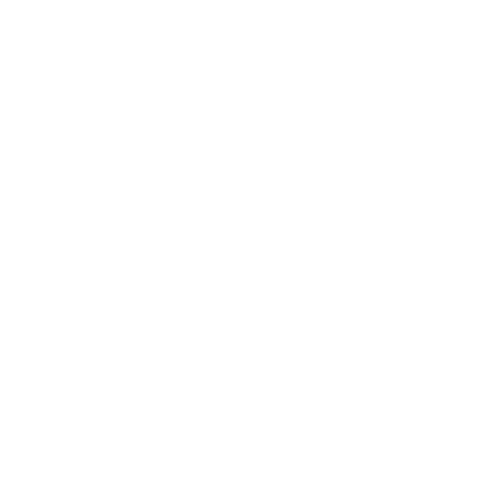

In [34]:
def agent_portrayal(agent):
    #renderizado de semaforos
    if isinstance(agent, (Semaphore, SecondarySemaphore)):
        #determinamos estado desde el agente o su primario
        state = agent.state if isinstance(agent, Semaphore) else agent.primary.state
        orientation = agent.orientation
        color = "grey"
        
        #logica de colores estilo chessboard
        if state == "yellow":
            color = "#FFFF00"
        elif state == "green_ns":
            #si es vertical verde si es horizontal rojo
            color = "#00FF00" if orientation == "vertical" else "#FF0000"
        elif state == "green_ew":
            #si es horizontal verde si es vertical rojo
            color = "#00FF00" if orientation == "horizontal" else "#FF0000"
            
        return AgentPortrayalStyle(color=color, size=60)
    
    #renderizado de coches
    if isinstance(agent, Car):
        return AgentPortrayalStyle(color="blue", size=40)

def road_portrayal(layer):
    #renderizado del mapa
    if layer.name == "road":
        return PropertyLayerStyle(colormap="Greys", alpha=0.3, vmin=0, vmax=3, colorbar=False)
    return None

#parametros de configuracion del modelo
model_params = {
    "num_cars": {
        "type": "SliderInt",
        "value": 10,
        "label": "Densidad:",
        "min": 1,
        "max": 40,
        "step": 1,
    }
}

#inicializacion para solara
model_instance = TrafficModel(num_cars=10)
renderer = SpaceRenderer(model=model_instance, backend="matplotlib").render(
    agent_portrayal=agent_portrayal,
    propertylayer_portrayal=road_portrayal
)

chart = make_plot_component("Queue", page=1) 

page = SolaraViz(
    model_instance,
    renderer,
    components=[chart],
    model_params=model_params,
    name="interseccion inteligente"
)
page